# Kelly and Hughes (2019) EDA and Covariance Analysis

## Setup

In [1]:
import os
import sys
import glob
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import re
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

In [3]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.variant_files as vf
from cvtk.gintervals import GenomicIntervals
from cvtk.pca import FreqPCA
from cvtk.bootstrap import bootstrap_ci
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.utils import extract_empirical_nulls_diagonals, extract_temporal_cov_diagonals
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group
from cvtk.variant_files import VCFFile

In [4]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

## Varianta Data Loading

### Load in TSV data and reshape

In [5]:
keep_seqids = ['2L', '2R', '3L', '3R', 'X']
keep_autos = ['2L', '2R', '3L', '3R']

In [6]:
rawdata = pd.read_csv('../data/kelly_hughes_2019/kelly_hughes_2019.tsv', delimiter='\t')
samples = ['A0', 'A7', 'B0', 'B7', 'C0', 'C7']
freqs = rawdata[[f"{samp}_pr" for samp in samples]].values.T
depths = rawdata[[f"{samp}_reads" for samp in samples]].values.T

In [7]:
gi = GenomicIntervals()
for row in rawdata.itertuples(index=False):
    seqid = row[0].replace('Scf_', '')
    gi.append(seqid, int(row[1]))

In [8]:
gi.infer_seqlens()

### Study Design

The design is three replicates (1, 2, 3) and two timepoints (0 and 7). There are 14 generations — the "7" comes from the seven months that the evolution experiment was run (see p. 945).

In [11]:
samples = [('A', 0), ('A', 7), ('B', 0), ('B', 7), ('C', 0), ('C', 7)]


## Replicate Covariance Analysis

In [12]:
tiles = GenomicIntervals.from_tiles(gi.seqlens, width=1e6)

In [13]:
d = TiledTemporalFreqs(tiles, freqs=freqs, depths=depths, diploids=1000, gintervals=gi, samples=samples)

In [14]:
d.samples

[('A', 0), ('A', 7), ('B', 0), ('B', 7), ('C', 0), ('C', 7)]

In [39]:
d.freqs.shape

(3, 2, 291272)

In [15]:
covs_cis = d.bootstrap_cov(B=5000, progress_bar=True, average_replicates=False)

In [16]:
covs_cis

array([[[0.01830569, 0.00637459, 0.00640242],
        [0.00637459, 0.01845631, 0.00613284],
        [0.00640242, 0.00613284, 0.01798777]],

       [[0.01929833, 0.00717879, 0.00720045],
        [0.00717879, 0.01931039, 0.00693249],
        [0.00720045, 0.00693249, 0.0187621 ]],

       [[0.02081173, 0.00858821, 0.00857097],
        [0.00858821, 0.02079733, 0.00835699],
        [0.00857097, 0.00835699, 0.02002122]]])

In [17]:
with open('../data/kelly_hughes_2019/kelly_hughes_2019_covs_bootstrap.npy', 'wb') as f:
    np.save(f, covs_cis)

### Bootstrap the Convergence Correlation

In [21]:
conv_corr = d.convergence_corr()
conv_corr

array([[[0.37148816]]])

In [22]:
with open('../data/kelly_hughes_2019/kelly_hughes_2019_conv_corr.npy', 'wb') as f:
    np.save(f, conv_corr)

In [23]:
conv_corr_cis = d.bootstrap_convergence_corr(B=5000, progress_bar=True)

In [18]:
conv_corr_cis

array([[[[0.33933085]]],


       [[[0.37148255]]],


       [[[0.42603002]]]])

In [19]:
with open('../data/kelly_hughes_2019/kelly_hughes_2019_conv_corr_cis.npy', 'wb') as f:
    np.save(f, conv_corr_cis)

## Convergent Correlation per Comparison

In [40]:
conv_corr_cis_0_1 = d.bootstrap_convergence_corr(B=5000, 
                                                 keep_seqids=keep_autos,
                                                 progress_bar=True, subset=(0, 1))
conv_corr_cis_1_2 = d.bootstrap_convergence_corr(B=5000,
                                                 keep_seqids=keep_autos,                                                 
                                                 progress_bar=True, subset=(1, 2))
conv_corr_cis_0_2 = d.bootstrap_convergence_corr(B=5000, 
                                                 keep_seqids=keep_autos,                                                 
                                                 progress_bar=True, subset=(0, 2))

/home/vsb/projects/cvtk/cvtk/cov.py:283: RuntimeWarning: Mean of empty slice
  mean_hets = np.nanmean(hets, axis=freqs.ndim-1)
/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/vsb/projects/cvtk/cvtk/cov.py:309: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(deltas, bias=True)
/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/vsb/projects/cvtk/cvtk/cov.py:338: R

In [41]:
kh_conv_corrs = np.stack((conv_corr_cis_0_1, 
                          conv_corr_cis_1_2,
                          conv_corr_cis_0_2)).squeeze()
kh_conv_corrs

array([[0.29881068, 0.3478147 , 0.39823043],
       [0.29762282, 0.34768237, 0.4027719 ],
       [0.31176254, 0.36009163, 0.41268878]])

In [42]:
with open('../data/kelly_hughes_2019/kelly_hughes_2019_all_conv_corr_cis.npy', 'wb') as f:
    np.save(f, kh_conv_corrs)

## Genome-wide Covariances

In [20]:
gw_covs = d.calc_cov(bias_correction=True)

In [21]:
gw_covs

array([[0.01929766, 0.00717835, 0.00720031],
       [0.00717835, 0.01931011, 0.00693239],
       [0.00720031, 0.00693239, 0.01876208]])

### Convergence G

A simple estimate:

In [56]:
# this is specific to this design
def rep_G(covs, standardize=True):
    out = ((covs[0,1]+ covs[1,2] + covs[0,2])/3)
    if standardize:
        return out/(np.diag(covs).mean())
    return out

rep_G(gw_covs)

0.37146787518860336

In [58]:
windowed_covs = d.calc_cov_by_tile()                            

In [62]:
B = 5000

windowed_rep_G_num = np.array([rep_G(win, False) for win in windowed_covs])
windowed_rep_G_denom = np.array([np.diag(win).mean() for win in windowed_covs])

straps = []
for b in np.arange(B):
    bidx = np.random.randint(0, len(windowed_covs), len(windowed_covs))
    g = windowed_rep_G_num[bidx].mean() / windowed_rep_G_denom[bidx].mean()
    straps.append(g)
    
print(bootstrap_ci(rep_G(gw_covs), straps))

[0.28897689 0.37146788 0.40572826]


## Loading Recombination Maps

In [45]:
file = '../data/dsimulans/howie_et_al_maps/15_recombination_map_loess_Dsim_0.1.csv'

dsim_map = pd.read_csv(file).sort_values(by=['sequence_name', 'start'])

In [47]:
dsim_map['midpoint'] = (dsim_map['start'].values + dsim_map['stop'].values)/2
dsim_map['cummidpoint'] = dsim_map['midpoint'].values.cumsum()
dsim_map.head()

,Species,sequence_name,start,stop,recombination_rate_cM_Mb_,midpoint,cummidpoint
20581,Dsim,2L,1,1000,0.847291,500.5,500.5
20582,Dsim,2L,1001,2000,0.850532,1500.5,2001.0
20583,Dsim,2L,2001,3000,0.853775,2500.5,4501.5
20584,Dsim,2L,3001,4000,0.857019,3500.5,8002.0
20585,Dsim,2L,4001,5000,0.860264,4500.5,12502.5


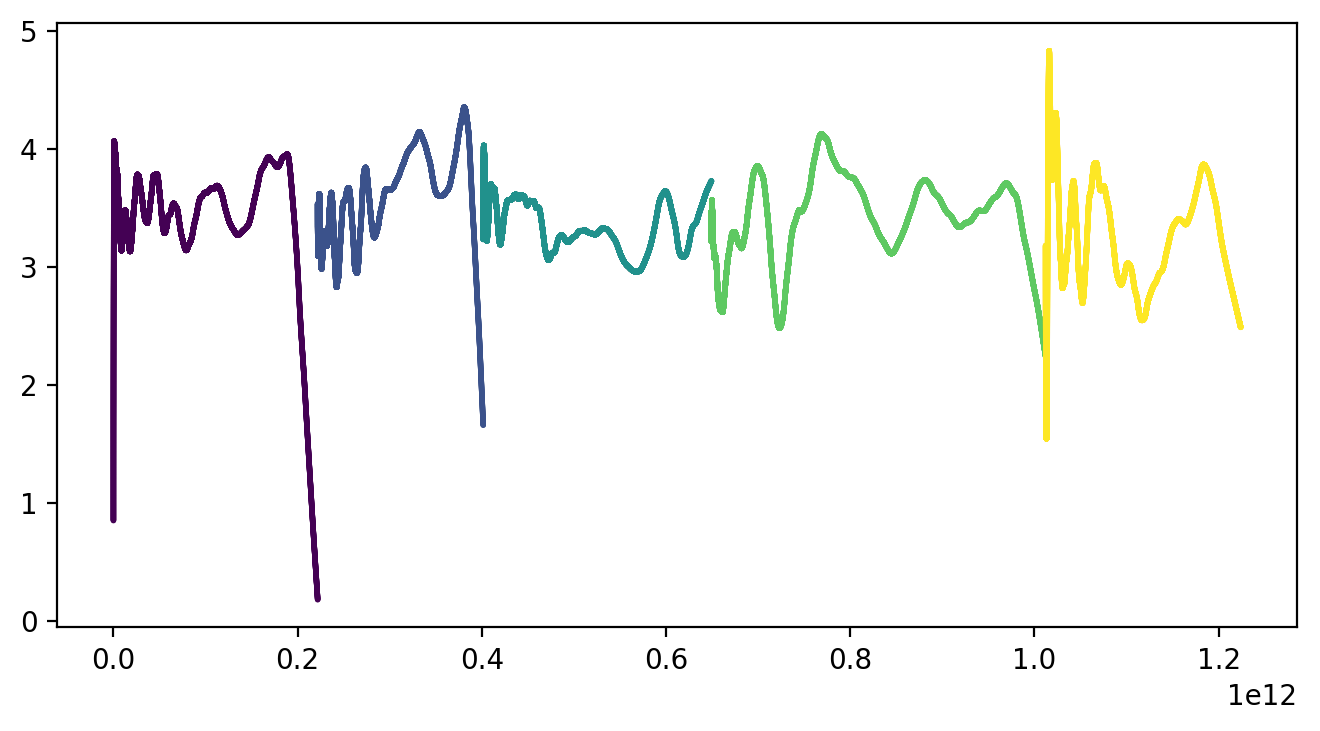

In [50]:
plt.scatter(dsim_map['cummidpoint'].values, dsim_map['recombination_rate_cM_Mb_'],
            c=integerize(dsim_map['sequence_name'].values),
           s=1)


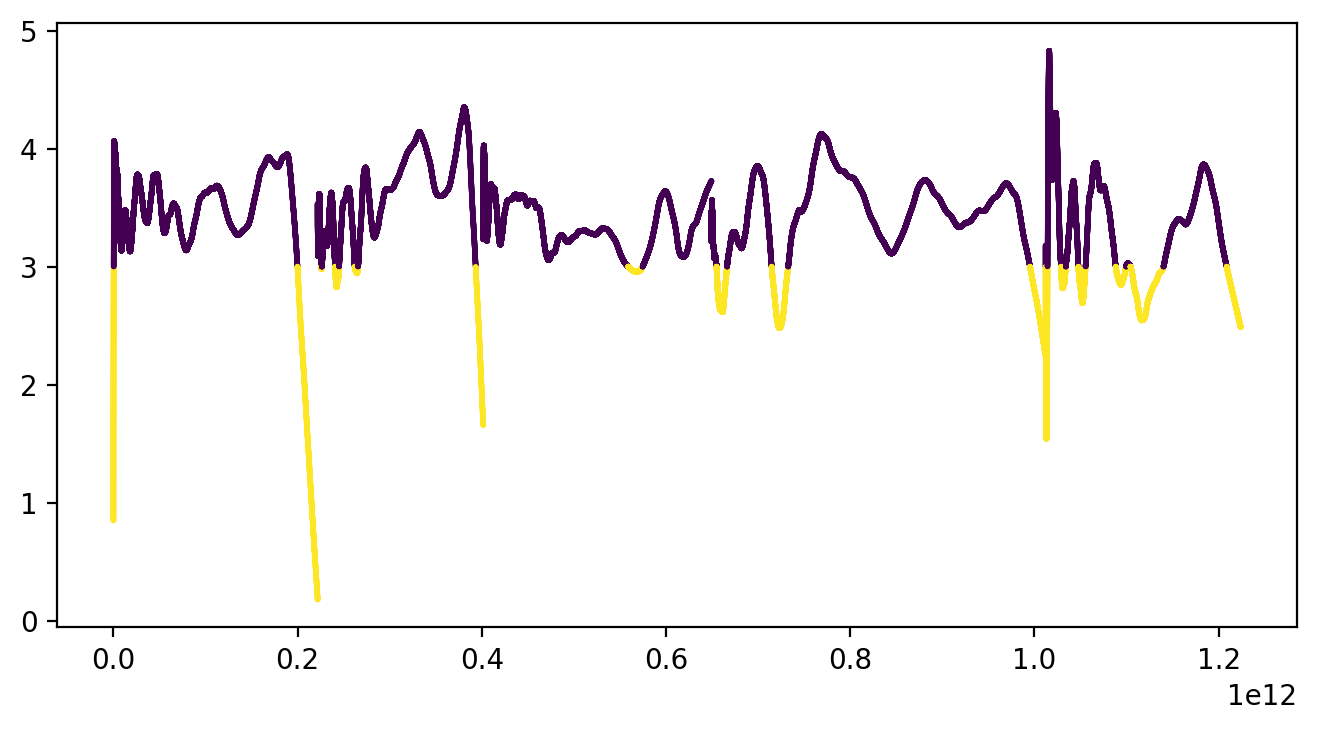

In [51]:
plt.scatter(dsim_map['cummidpoint'].values, dsim_map['recombination_rate_cM_Mb_'],
            c=integerize(dsim_map['recombination_rate_cM_Mb_'].values < 3),
           s=1)


/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


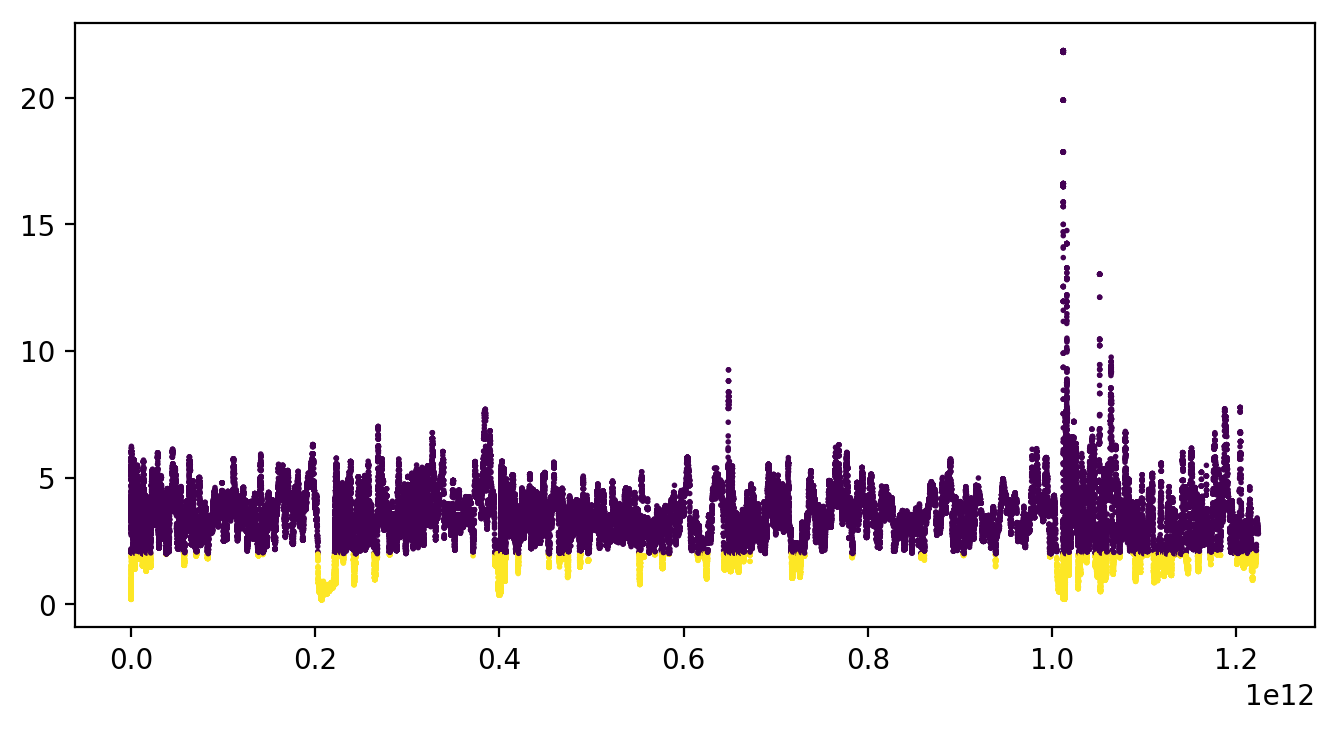

In [40]:
plt.scatter(dsim_map['cummidpoint'].values, dsim_map['recombination_rate_cM_Mb_'],
            c=integerize(dsim_map['recombination_rate_cM_Mb_'].values < 2),
            s=1)
